<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/03_benchmark_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark Selection with Regression Analysis
This model aims to select an ETF that best fits with the portfolio to be used as a benchmark. The methodology uses a regression analysis to identify the relationship between the ETF and the portfolio and check the ETF with the highest R² and lowest p-value will be selected as the benchmark. 

The model will use the following steps:
1. Select an ETF that invests in the same sectors as the portfolio holdings.
2. Use regression analysis to identify the relationship between the ETF and the portfolio.
3. Select the ETF with the highest R² and lowest p-value as the benchmark.
4. Use the selected ETF as a benchmark to evaluate the performance of the portfolio.

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, export_to_excel
from py.regression_benchmark import find_best_benchmark_and_run_regressions

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Excel libraries
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font
import ast

### Step 2: Define Parameters

#### Dates

In [2]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            # 10 years ago from the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-07 to 2025-06-04
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [3]:
# Load and process data
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433 
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
risk_free_rate_monthly = risk_free_rate / 12

# Display result
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")
daily_risk_free_df.head()

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


,^IRX
Date,
2015-06-08,0.010
2015-06-09,0.013
2015-06-10,0.013
2015-06-11,0.008
2015-06-12,0.005


#### Report File

In [4]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-04.xlsx


### Step 3: Read ETF Data

In [5]:
# Load Data
sectors_df = pd.read_csv("data/fundamentals_benchmark.csv") 
sectors_df = sectors_df[["Ticker", "Name", "Sector Weightings"]]
sectors_df = sectors_df.rename(columns={"Name": "Name", "Ticker": "Symbol", "Sector Weightings": "Sectors"})

# Convert string representations of dictionaries to actual dictionaries
sectors_df['Sectors'] = sectors_df['Sectors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else {})

# Display
sectors_df.head()

,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0...."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AGNG,Global X Aging Population ETF,"{'realestate': 0.0791, 'consumer_cyclical': 0...."


### Step 4: Read Portfolio Data (Excel)

In [6]:
portfolio_df = pd.read_excel(output_file, sheet_name="short_term")   
portfolio_tickers = portfolio_df["Ticker"].tolist()
# portfolio_df["Weight"] = portfolio_df['Weight'].str.rstrip('%').astype(float) / 100
portfolio_df["P/E (Trailing)"] = pd.to_numeric(portfolio_df["P/E (Trailing)"], errors="coerce")

print(portfolio_tickers)
display(portfolio_df)

['GRMN', 'MSFT']


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
0,GRMN,2025-06-02,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,39080046592,36584062976,174794910,...,10,190,7,0.6018,0.0000,0.4286,0.2036,0.4921,0.5663,0.5
1,MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3421643997184,3447046799360,7422063978,...,30,190,37,0.6028,0.0541,0.5405,0.2057,0.4921,0.5663,0.5


### Step 5: Benchmark Sector Screening

#### Filter Sectors by Portfolio

In [7]:
# Sort portfolio sectors by weight (descending)
portfolio_sector_weights = (
    portfolio_df.groupby('Sector')['Weight'].sum()
    .sort_values(ascending=False)
)
ordered_portfolio_sectors = [sector.strip() for sector in portfolio_sector_weights.index]
normalized_ordered_portfolio_sectors = [sector.strip().lower().replace(" ", "_") for sector in ordered_portfolio_sectors]

# Filter directly with lambda expression instead of using a separate function
filtered_sectors_df = sectors_df[
    sectors_df['Sectors'].apply(
        lambda sector_dict: isinstance(sector_dict, dict) and all(
            sector in sector_dict and sector_dict[sector] > 0 
            for sector in normalized_ordered_portfolio_sectors
        )
    )
].reset_index(drop=True)

# Display Outputs
tickers = filtered_sectors_df["Symbol"].tolist()
print("Number of benchmarks left:", len(tickers))
display(filtered_sectors_df.head())

Number of benchmarks left: 374


,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0...."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0047999998, 'consumer_cyclica..."


#### Import ETF Fundamental Data

In [8]:
# fundamentals_df = fetch_fundamentals(tickers) # Download fundamentals data for the tickers
fundamentals_df = pd.read_csv("data/fundamentals_benchmark.csv",index_col="Ticker").query("Ticker in @tickers") # Import the fundamentals data from a CSV file

# Set the index name
fundamentals_df.index.name = "Symbol"

# Move the index into a column
fundamentals_df = fundamentals_df.reset_index()

# Perform the merge
merged_df = pd.merge(filtered_sectors_df, fundamentals_df, on='Symbol', how='inner').dropna(how='all', axis=1)

# Display the merged DataFrame
display(merged_df.head())

,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118...",2025-06-02,AdvisorShares Dorsey Wright ADR ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,77.58,Unknown,81.17,54.57,74.66,70.09,"{""realestate"": 0.0, ""consumer_cyclical"": 0.118..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118...",2025-06-02,Abacus FCF Leaders ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,69.15,Unknown,71.28,55.40,64.73,66.17,"{""realestate"": 0.0, ""consumer_cyclical"": 0.118..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0....",2025-06-02,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,123.65,Unknown,124.54,101.25,117.25,118.68,"{""realestate"": 0.0216, ""consumer_cyclical"": 0...."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0047999998, 'consumer_cyclica...",2025-06-02,iShares Asia 50 ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,74.67,Unknown,77.87,59.33,71.89,71.02,"{""realestate"": 0.0047999998, ""consumer_cyclica..."


#### Filter for the P/E (Trailling) Similar to Portfolio Weighted Average P/E

In [9]:
# Step 1: Calculate the weighted average of P/E (Trailing) in portfolio_df
weighted_average_pe = (portfolio_df["Weight"] * portfolio_df["P/E (Trailing)"]).sum()

# Step 2: Calculate the 20% threshold range
lower_bound = weighted_average_pe * 0.8  # 20% below the weighted average
upper_bound = weighted_average_pe * 1.2  # 2% above the weighted average

# Step 3: Filter merged_df based on the P/E (Trailing) column
filtered_merged_df = merged_df[
    (merged_df["P/E (trailing)"] >= lower_bound) & 
    (merged_df["P/E (trailing)"] <= upper_bound)
]

filtered_sectors_df = filtered_merged_df.copy().dropna(how='all')
tickers = filtered_sectors_df["Symbol"].tolist()

# Display the filtered DataFrame
print("Portfolio Weighted Average P/E (trailing):", weighted_average_pe)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of benchmarks after filtering by P/E (trailing):", len(filtered_merged_df))
display(filtered_sectors_df.head())

Portfolio Weighted Average P/E (trailing): 31.159999999999997
Lower Bound: 24.927999999999997
Upper Bound: 37.391999999999996
Number of benchmarks after filtering by P/E (trailing): 91


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118...",2025-06-02,Abacus FCF Leaders ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,69.15,Unknown,71.28,55.40,64.73,66.17,"{""realestate"": 0.0, ""consumer_cyclical"": 0.118..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
5,AIQ,Global X Artificial Intelligence & Technology ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.102...",2025-06-02,Global X Artificial Intelligence & Technology ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,40.30,Unknown,42.78,30.60,37.32,37.94,"{""realestate"": 0.0, ""consumer_cyclical"": 0.102..."
11,BAPR,Innovator U.S. Equity Buffer ETF - April,"{'realestate': 0.0224, 'consumer_cyclical': 0....",2025-06-02,Innovator U.S. Equity Buffer ETF - April,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,43.98,Unknown,46.04,38.21,42.39,43.57,"{""realestate"": 0.0224, ""consumer_cyclical"": 0...."
12,BBUS,JPMorgan BetaBuilders U.S. Equity ETF,"{'realestate': 0.0231, 'consumer_cyclical': 0....",2025-06-02,JPMorgan BetaBuilders U.S. Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,106.74,Unknown,111.04,86.94,101.02,104.33,"{""realestate"": 0.0231, ""consumer_cyclical"": 0...."


### Step 6: Import Quotes

#### Benchmark Tickers

In [10]:
# Load and filter historical benchmark price data
benchmark_prices_daily_df = load_and_filter_data('data/daily_benchmark_quotes.csv', tickers, start_date, end_date)
benchmark_prices_monthly_df = load_and_filter_data('data/monthly_benchmark_quotes.csv', tickers, start_date, end_date)

# Display the first few rows
benchmark_prices_monthly_df.head()

Found 87 of 91 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['ILCB', 'MOAT', 'PTNQ', 'XSD']
Found 87 of 91 tickers in data/monthly_benchmark_quotes.csv
Missing tickers: ['ILCB', 'MOAT', 'PTNQ', 'XSD']


,ABFL,ADME,AIQ,BAPR,BBUS,BJAN,BJUL,BOCT,CIBR,CWS,...,VOOG,VOT,VUG,VUSE,VV,XLG,XLI,XLK,XLY,XNTK
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.89,NaN,...,94.97,100.33,101.11,23.30,81.86,12.63,45.37,37.85,71.89,38.31
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.89,NaN,...,89.17,94.47,94.74,22.28,76.92,11.78,42.92,35.76,67.19,36.52
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.29,NaN,...,87.11,90.66,92.03,21.21,74.82,11.54,41.97,35.27,66.80,35.83
2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.03,NaN,...,95.32,95.74,100.29,22.56,81.02,12.68,45.66,38.98,72.84,39.65
2015-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.64,NaN,...,95.45,95.71,100.44,23.00,81.30,12.74,46.05,39.26,72.66,40.07


#### Portfolio Tickers

In [11]:
# Load and filter historical benchmark price data
stock_prices_monthly_df = load_and_filter_data('data/monthly_stock_quotes.csv', portfolio_tickers, start_date, end_date)

# Display the first few rows
stock_prices_monthly_df.head()

Found 2 of 2 tickers in data/monthly_stock_quotes.csv
Missing tickers: []


,GRMN,MSFT
Date,,
2015-07-01,31.29,40.49
2015-08-01,28.08,37.98
2015-09-01,27.17,38.63
2015-10-01,26.86,45.94
2015-11-01,28.66,47.76


### Step 7: Prepare Data (Drop Invalid Tickers)

#### Daily Quotes

In [12]:
# Identify columns with null values in first or last 50 rows
first_50_nulls = benchmark_prices_daily_df.head(50).isnull().any()
last_50_nulls = benchmark_prices_daily_df.tail(50).isnull().any()

# Columns to drop are those with nulls in first 50 OR last 50 rows
columns_to_drop = first_50_nulls | last_50_nulls
bad_columns = columns_to_drop[columns_to_drop].index.tolist()

print(f"Dropping {len(bad_columns)} columns with missing values in first/last 50 records: {bad_columns}")

# Drop those columns
benchmark_prices_daily_df = benchmark_prices_daily_df.loc[:, ~columns_to_drop]

# Display the first few rows of the cleaned dataframe
benchmark_prices_daily_df.head()

Dropping 26 columns with missing values in first/last 50 records: ['ABFL', 'ADME', 'AIQ', 'BAPR', 'BBUS', 'BJAN', 'BJUL', 'BOCT', 'CIBR', 'CWS', 'ESPO', 'GVIP', 'HTUS', 'JMOM', 'NULG', 'PBUS', 'PJUL', 'POCT', 'QGRO', 'QMOM', 'QTUM', 'SPMO', 'SPXV', 'TBLU', 'TMFC', 'USMC']


,DSI,FAD,FDIS,FIDU,FTEC,GRID,IGM,ILCG,IMCG,INCO,...,VOOG,VOT,VUG,VUSE,VV,XLG,XLI,XLK,XLY,XNTK
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-08,33.57,48.74,27.71,24.47,29.72,33.20,16.81,22.24,26.13,25.51,...,92.05,99.29,98.52,23.86,80.77,12.32,46.17,37.59,67.87,37.10
2015-06-09,33.54,48.58,27.67,24.45,29.67,33.20,16.74,22.21,26.05,25.17,...,91.97,99.08,98.37,23.85,80.76,12.32,46.16,37.50,67.80,37.10
2015-06-10,33.97,49.17,27.96,24.70,30.13,33.13,17.02,22.48,26.36,25.96,...,93.08,100.07,99.53,24.15,81.71,12.48,46.62,38.08,68.50,37.75
2015-06-11,34.04,49.26,28.03,24.78,30.12,32.85,17.01,22.52,26.42,25.28,...,93.26,100.50,99.75,24.14,81.90,12.49,46.88,38.10,68.73,37.71
2015-06-12,33.84,49.19,27.94,24.65,29.89,33.14,16.89,22.34,26.32,25.31,...,92.66,100.12,99.12,24.09,81.36,12.41,46.61,37.76,68.42,37.40


#### Monthly Quotes

In [13]:
benchmark_prices_monthly_df = (benchmark_prices_daily_df.set_index(pd.to_datetime(benchmark_prices_daily_df.pop('Date')))
      if 'Date' in benchmark_prices_daily_df.columns else benchmark_prices_daily_df.copy())
benchmark_prices_monthly_df.index = pd.to_datetime(benchmark_prices_monthly_df.index)              
benchmark_prices_monthly_df = (benchmark_prices_monthly_df.resample('MS').last()
   .reset_index()
   .rename(columns={'index': 'Date'}))

benchmark_prices_monthly_df.set_index('Date', inplace=True)
display(benchmark_prices_monthly_df.head())

,DSI,FAD,FDIS,FIDU,FTEC,GRID,IGM,ILCG,IMCG,INCO,...,VOOG,VOT,VUG,VUSE,VV,XLG,XLI,XLK,XLY,XNTK
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,33.28,49.02,27.91,24.02,29.08,32.15,16.44,22.21,26.03,26.97,...,91.66,98.89,97.91,23.66,80.17,12.23,45.23,36.80,68.54,36.30
2015-07-01,34.01,50.14,29.02,23.92,29.72,30.88,17.09,23.16,26.53,28.46,...,94.97,100.33,101.11,23.30,81.86,12.63,45.37,37.85,71.89,38.31
2015-08-01,31.94,47.27,27.20,22.68,28.01,29.65,16.16,21.63,24.86,25.33,...,89.17,94.47,94.74,22.28,76.92,11.78,42.92,35.76,67.19,36.52
2015-09-01,31.16,45.48,26.75,21.91,27.60,28.51,15.94,21.01,23.72,24.67,...,87.11,90.66,92.03,21.21,74.82,11.54,41.97,35.27,66.80,35.83
2015-10-01,33.89,48.30,28.86,23.85,30.56,29.74,17.74,23.10,24.99,25.04,...,95.32,95.74,100.29,22.56,81.02,12.68,45.66,38.98,72.84,39.65


### Step 8: Calculate Returns (Lognormal)

#### Benchmark

In [14]:
benchmark_log_returns_df = np.log(benchmark_prices_monthly_df / benchmark_prices_monthly_df.shift(1))
benchmark_log_returns_df = benchmark_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
benchmark_log_returns_df.head()

,DSI,FAD,FDIS,FIDU,FTEC,GRID,IGM,ILCG,IMCG,INCO,...,VOOG,VOT,VUG,VUSE,VV,XLG,XLI,XLK,XLY,XNTK
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0.021698,0.022591,0.039000,-0.004172,0.021770,-0.040304,0.038776,0.041884,0.019026,0.053774,...,0.035475,0.014457,0.032160,-0.015332,0.020861,0.032183,0.003091,0.028133,0.047720,0.053893
2015-08-01,-0.062795,-0.058943,-0.064768,-0.053231,-0.059259,-0.040647,-0.055954,-0.068345,-0.065016,-0.116510,...,-0.063016,-0.060182,-0.065073,-0.044764,-0.062245,-0.069672,-0.055513,-0.056801,-0.067613,-0.047851
2015-09-01,-0.024724,-0.038603,-0.016682,-0.034540,-0.014746,-0.039207,-0.013707,-0.029083,-0.046942,-0.026402,...,-0.023373,-0.041166,-0.029022,-0.049217,-0.027681,-0.020584,-0.022383,-0.013797,-0.005821,-0.019075
2015-10-01,0.083985,0.060159,0.075922,0.084841,0.101876,0.042238,0.106990,0.094834,0.052157,0.014887,...,0.090068,0.054520,0.085951,0.061706,0.079611,0.094207,0.084268,0.100016,0.086562,0.101305
2015-11-01,0.001769,0.008453,-0.005908,0.013742,0.010417,0.003022,0.012882,0.003889,0.003196,0.000399,...,0.001363,-0.000313,0.001495,0.019316,0.003450,0.004721,0.008505,0.007157,-0.002474,0.010537


#### Stocks

In [15]:
stock_log_returns_df = np.log(stock_prices_monthly_df / stock_prices_monthly_df.shift(1))
stock_log_returns_df = stock_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
stock_log_returns_df.head()

,GRMN,MSFT
Date,,
2015-08-01,-0.108241,-0.063995
2015-09-01,-0.032944,0.016969
2015-10-01,-0.011475,0.173307
2015-11-01,0.064864,0.038852
2015-12-01,-0.004546,0.020517


### Step 9: Calculate Excess Return (Expected Return - Risk-free Rate)

#### Benchmark

In [16]:
benchmark_excess_returns_df = benchmark_log_returns_df - risk_free_rate_monthly
benchmark_excess_returns_df.head()

,DSI,FAD,FDIS,FIDU,FTEC,GRID,IGM,ILCG,IMCG,INCO,...,VOOG,VOT,VUG,VUSE,VV,XLG,XLI,XLK,XLY,XNTK
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0.018165,0.019057,0.035467,-0.007705,0.018236,-0.043837,0.035243,0.038351,0.015493,0.050241,...,0.031942,0.010923,0.028627,-0.018866,0.017328,0.028650,-0.000443,0.024600,0.044186,0.050360
2015-08-01,-0.066329,-0.062477,-0.068302,-0.056765,-0.062792,-0.044180,-0.059488,-0.071879,-0.068549,-0.120043,...,-0.066550,-0.063716,-0.068606,-0.048297,-0.065778,-0.073205,-0.059047,-0.060334,-0.071146,-0.051384
2015-09-01,-0.028257,-0.042137,-0.020216,-0.038074,-0.018279,-0.042741,-0.017241,-0.032616,-0.050475,-0.029935,...,-0.026906,-0.044699,-0.032555,-0.052750,-0.031214,-0.024117,-0.025916,-0.017331,-0.009355,-0.022608
2015-10-01,0.080451,0.056626,0.072389,0.081308,0.098343,0.038705,0.103457,0.091301,0.048624,0.011353,...,0.086535,0.050987,0.082418,0.058172,0.076077,0.090673,0.080734,0.096483,0.083029,0.097772
2015-11-01,-0.001764,0.004919,-0.009441,0.010208,0.006883,-0.000512,0.009348,0.000355,-0.000337,-0.003134,...,-0.002170,-0.003847,-0.002039,0.015782,-0.000083,0.001187,0.004972,0.003624,-0.006008,0.007004


#### Stocks

In [17]:
stock_excess_returns_df = stock_log_returns_df - risk_free_rate_monthly
stock_excess_returns_df.head()

,GRMN,MSFT
Date,,
2015-08-01,-0.111774,-0.067529
2015-09-01,-0.036477,0.013436
2015-10-01,-0.015009,0.169774
2015-11-01,0.061331,0.035319
2015-12-01,-0.008080,0.016983


### Step 10: Find the Best Benchmark (By Regression Coefficients)

In [18]:
# Call the function with your data
best_benchmark, benchmark_stats_df, best_benchmarks_df = find_best_benchmark_and_run_regressions(
    benchmark_excess_returns_df, 
    stock_excess_returns_df
)

# Display the results
print(f"Best benchmark: {best_benchmark}")
display(best_benchmarks_df)

Best benchmark: DSI


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,GRMN,DSI,0.006167,0.941834,0.616574,0.380164,8.305727e-14,0.236861
1,MSFT,DSI,0.010754,0.959018,0.754521,0.569302,3.851822e-23,0.003411


In [19]:
# Display the benchmark statistics
display(benchmark_stats_df.sort_values(by="score", ascending=False).head(10))

,benchmark,avg_slope,slope_std,avg_p_value_intercept,avg_p_value_slope,avg_r_squared,beta_quality,score
0,DSI,0.950426,0.008592,0.120136,4.152863e-14,0.474733,0.950426,0.859301
20,MGC,0.984338,0.007865,0.160098,4.193813e-14,0.473412,0.984338,0.857970
15,IWL,0.986026,0.010171,0.163109,4.285443e-14,0.475776,0.986026,0.857725
23,OEF,0.987367,0.029633,0.167721,1.153334e-13,0.485498,0.987367,0.855273
43,SPY,0.973157,0.017383,0.138181,1.524168e-14,0.457877,0.973157,0.855153
11,IVV,0.972157,0.016167,0.139801,1.680984e-14,0.457990,0.972157,0.854887
55,VV,0.963426,0.014536,0.135666,1.517966e-14,0.460858,0.963426,0.854858
50,VOO,0.972549,0.016142,0.140399,1.718177e-14,0.457758,0.972549,0.854805
33,QUAL,0.956262,0.028837,0.120215,3.430186e-15,0.462547,0.956262,0.854113
35,SCHX,0.962398,0.023355,0.133402,8.728939e-15,0.457825,0.962398,0.852800


### Step 11: Plot Results

📈 BENCHMARK REGRESSION ANALYSIS: DSI
🔍 GRMN: β=0.9418, R²=0.3802, p=0.0000, Weight=50.0%
🔍 MSFT: β=0.9590, R²=0.5693, p=0.0000, Weight=50.0%


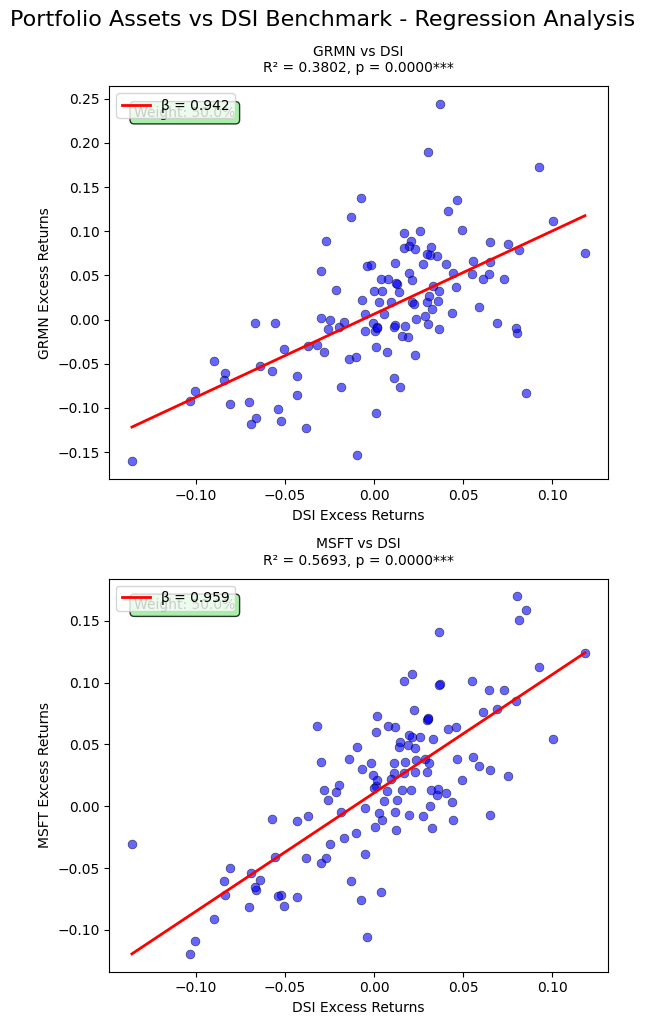


📊 BENCHMARK REGRESSION SUMMARY: DSI


,Ticker,Beta,Alpha,R_Squared,Correlation,P_Value,Portfolio_Weight,N_Observations,Significance
0,GRMN,0.9418,0.0062,0.3802,0.6166,0.0,0.5,119,***
1,MSFT,0.9590,0.0108,0.5693,0.7545,0.0,0.5,119,***



📈 PORTFOLIO STATISTICS: Weighted β=0.9504, Weighted R²=0.4747
  • Significant relationships (p<0.05): 2/2
Portfolio sectors: {'Technology'}
Benchmark sectors: {'Consumer Defensive', 'Technology', 'Energy', 'Industrials', 'Financial Services', 'Consumer Cyclical', 'Communication Services', 'Utilities', 'Basic Materials', 'Realestate', 'Healthcare'}


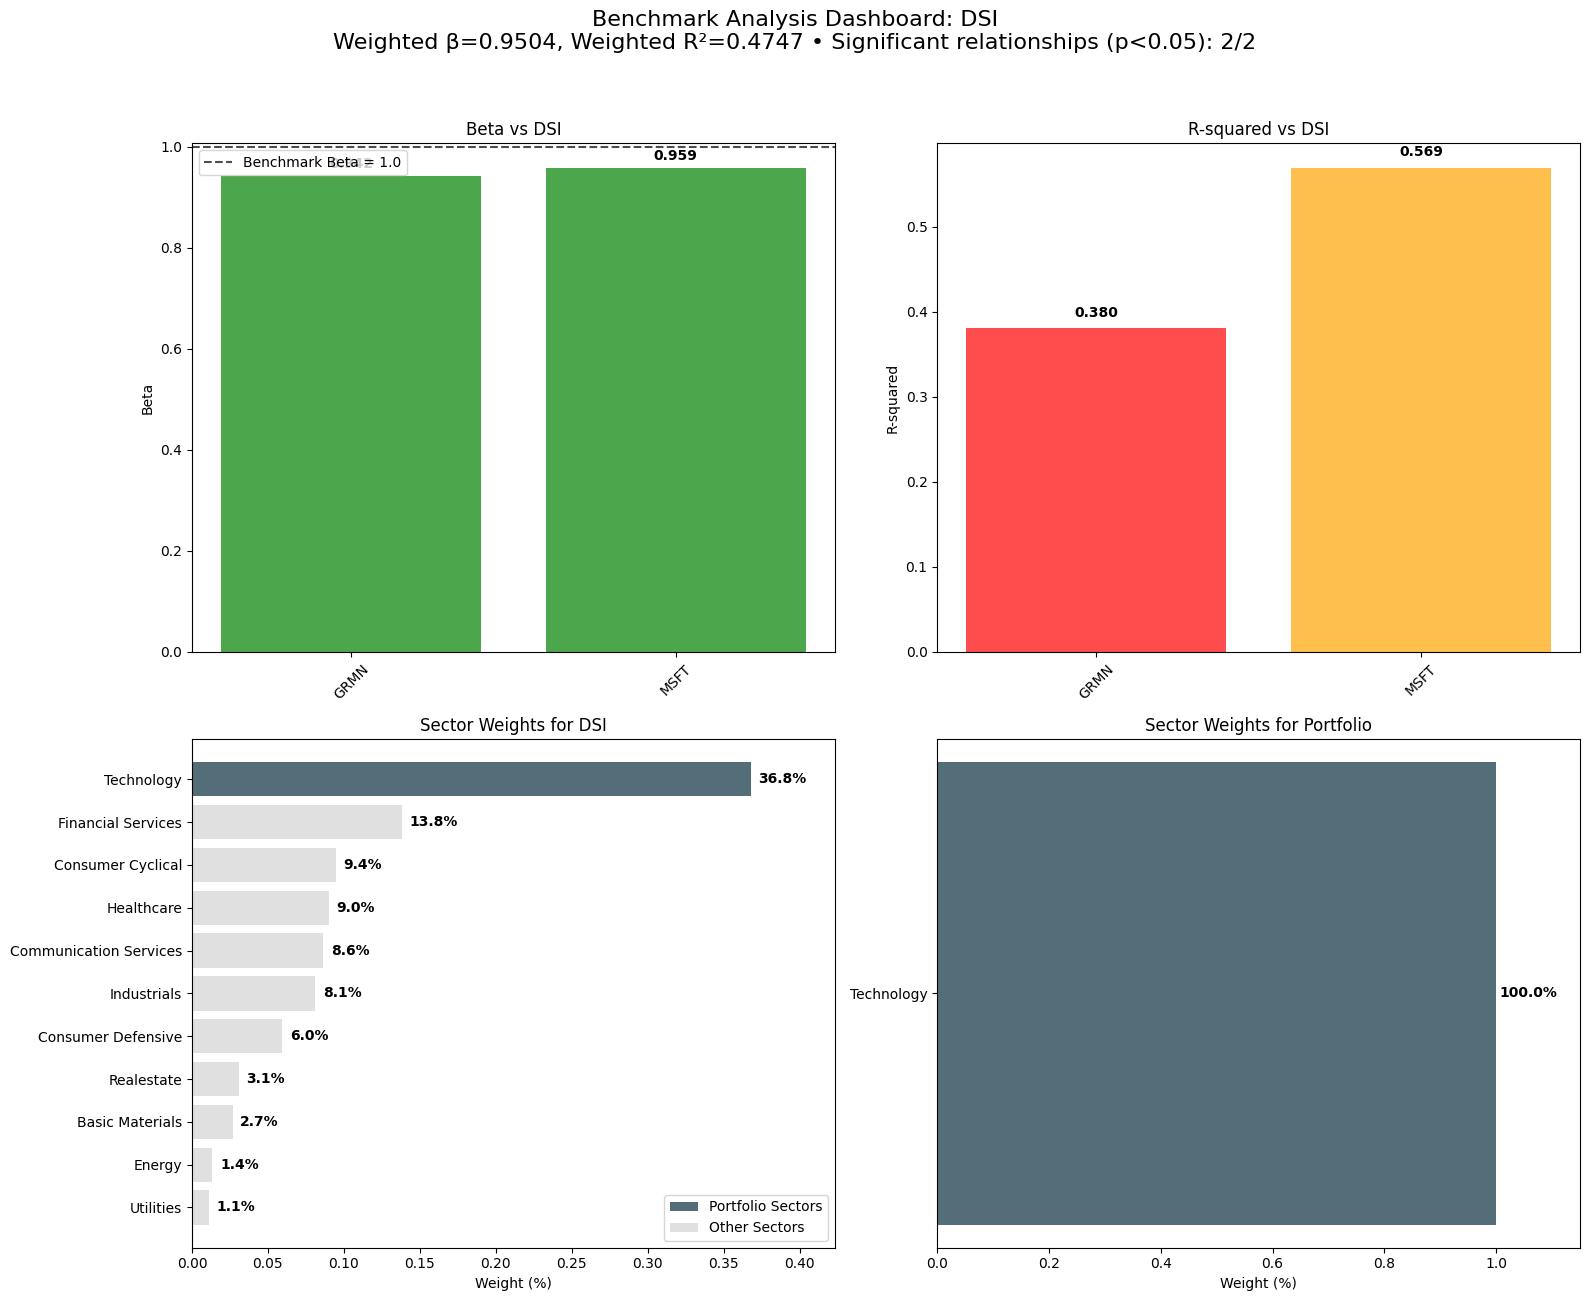

In [20]:
from py.regression_benchmark import analyze_benchmark_regression, plot_benchmark_analysis

# Execute analysis
benchmark_regression_results = analyze_benchmark_regression(benchmark_excess_returns_df, stock_excess_returns_df, best_benchmark, portfolio_df)

# Get the benchmark sector data
best_benchmark_sectors = filtered_sectors_df[filtered_sectors_df["Symbol"] == best_benchmarks_df['Benchmark'].unique()[0]]
best_benchmark_sectors = best_benchmark_sectors[["Symbol", "Name_x", "Sectors"]] 
best_benchmark_sectors = best_benchmark_sectors.rename(columns={"Name_x": "Name"})

# Create the analysis with sector weights
benchmark_regression_summary = plot_benchmark_analysis(
    regression_results=benchmark_regression_results, 
    best_benchmark=best_benchmark, 
    cols=1, 
    benchmark_sectors_df=best_benchmark_sectors,
    portfolio_df=portfolio_df 
)

### Step 12: Export Data to Excel

In [21]:
# Set Index
first_column = best_benchmarks_df.columns[0] # Get the name of the first column
best_benchmarks_df.set_index(first_column, drop=True, inplace=True)
best_benchmark = best_benchmarks_df['Benchmark'].unique()[0]

# Display the best benchmark DataFrame
print(best_benchmark)
best_benchmarks_df

DSI


,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
Equity,,,,,,,
GRMN,DSI,0.006167,0.941834,0.616574,0.380164,8.305727e-14,0.236861
MSFT,DSI,0.010754,0.959018,0.754521,0.569302,3.851822e-23,0.003411


In [22]:
export_to_excel(output_file, {
    'benchmark_short_term': best_benchmarks_df,
    'daily_quotes': benchmark_prices_daily_df[[best_benchmark]],  
    'monthly_quotes': benchmark_prices_monthly_df[[best_benchmark]]   
})

Updated sheet 'benchmark_short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-04.xlsx
